In [13]:
import s3fs
import numpy as np
import pandas as pd

from mvpa2.datasets.mri import fmri_dataset
from mvpa2 import cfg
import mvpa2.datasets as md
from mvpa2.measures import rsa
from mvpa2.mappers.fx import mean_group_sample

import pylab as pl

In [6]:
## Load the data file names
fs = s3fs.S3FileSystem(anon=True)
ll = fs.ls('natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR')
sess_beta_list = [l for l in ll if l.split('/')[6].startswith("betas") and l.endswith("nii.gz")]

behav_data = pd.read_csv('subj01/behav/final_response.tsv', sep='\t')

In [7]:
### Load the data
# load the first session
sess = 1
sess_fname = sess_beta_list[0]
print(f"Loading session {sess} data ...")
# load the session data
fs.get(sess_fname, "tmp.nii.gz")
sess_data = fmri_dataset("tmp.nii.gz", mask = "TPJfunc.nii")

# extract the behavioral data for the session
tmp_behav = behav_data[behav_data['SESSION'] == sess] 

# only take the trials that have an interaction_type (i.e., not null)
indices = tmp_behav['interaction_type'].notnull().tolist()

# take the beta values for those trials
all_sess_ds = sess_data[indices, :]

# add the target (interaction_type) and chunk (session) information to the dataset
all_sess_ds.sa['targets'] = tmp_behav[indices]['interaction_type'].tolist()
all_sess_ds.sa['chunks'] = tmp_behav[indices]['SESSION']

# add an attribute that determines whether the session should be included in the training or test dataset
if (sess) >=36:
    all_sess_ds.sa['train_or_test'] = ['test'] * len(all_sess_ds)
else:
    all_sess_ds.sa['train_or_test'] = ['train'] * len(all_sess_ds)
    
# add the 73KID as an attribute
    all_sess_ds.sa['ID'] = tmp_behav[indices]['73KID']

### then concatenate the other sessions to the first session
for sess, sess_fname in enumerate(sess_beta_list[1:3]): 
    print(f"Loading session {sess+2} data ...")
    # load the session data
    fs.get(sess_fname, "tmp.nii.gz")
    sess_data = fmri_dataset("tmp.nii.gz", mask = "TPJfunc.nii")

    # extract the behavioral data for the session
    tmp_behav = behav_data[behav_data['SESSION'] == (sess+2)] 

    # only take the trials that have an interaction_type (i.e., not null)
    indices = tmp_behav['interaction_type'].notnull().tolist()

    # take the beta values for those trials
    tmp_ds = sess_data[indices, :]

    # add the target (interaction_type) and chunk (session) information to the dataset
    tmp_ds.sa['targets'] = tmp_behav[indices]['interaction_type'].tolist()
    tmp_ds.sa['chunks'] = tmp_behav[indices]['SESSION']
    
    # add an attribute that determines whether the session should be included in the training or test dataset
    if (sess+2) >=36:
        tmp_ds.sa['train_or_test'] = ['test'] * len(tmp_ds)
    else:
        tmp_ds.sa['train_or_test'] = ['train'] * len(tmp_ds)
        
    # add the 73KID as an attribute
    tmp_ds.sa['ID'] = tmp_behav[indices]['73KID']
    
    # concatenate the tmp_ds to the all_sess_ds
    all_sess_ds = md.vstack((all_sess_ds, tmp_ds))

Loading session 1 data ...


/srv/conda/envs/notebook/lib/python3.7/site-packages/mvpa2/datasets/mri.py:78: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data, header = img.get_data(), img.header


 * Please note: warnings are printed only once, but underlying problem might occur many times *
Loading session 2 data ...
Loading session 3 data ...


In [8]:
print(f"Dataset shape is: {all_sess_ds.shape}")

Dataset shape is: (37, 1000)


In [9]:
## convert the integer values to percent change (according to https://cvnlab.slite.com/p/6CusMRYfk0/Functional-data-NSD)
normalized_all_sess_ds = all_sess_ds.copy()
normalized_all_sess_ds.samples = normalized_all_sess_ds.samples.astype('float')/300
normalized_all_sess_ds.samples

array([[-5.33333333e-02,  2.73333333e-01,  1.63333333e-01, ...,
        -1.10666667e+00, -1.82000000e+00,  1.97000000e+00],
       [-3.46666667e-01,  2.00000000e-01, -1.17333333e+00, ...,
        -1.58666667e+00,  1.56000000e+00, -1.22666667e+00],
       [ 2.33333333e-01,  2.18333333e+00, -1.84000000e+00, ...,
        -7.66666667e-02,  1.33333333e-02,  1.39000000e+00],
       ...,
       [ 6.73333333e-01, -3.00000000e-01, -1.73333333e-01, ...,
         7.05666667e+00, -6.90000000e-01, -1.23400000e+01],
       [-7.10000000e-01,  9.53333333e-01, -2.17333333e+00, ...,
         2.21000000e+00, -1.90000000e-01, -1.85600000e+01],
       [ 8.73333333e-01, -9.66666667e-02, -2.33333333e-02, ...,
        -2.77666667e+00,  5.70000000e-01,  5.04333333e+00]])

In [20]:
## average the samples that have the same 73KID, because each image is repeated three times
ds = normalized_all_sess_ds.get_mapped(mean_group_sample(['ID']))

In [35]:
## Helper function to plot the dissimilarity matrices
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0, 2))
    pl.colorbar()

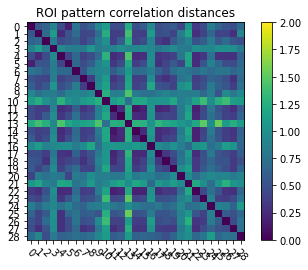

In [36]:
# basic ROI RSA -- dissimilarity matrix for the entire ROI
dsm = rsa.PDist(square=True, pairwise_metric='correlation')  # also test 'euclidean'
res = dsm(ds)
plot_mtx(res, np.arange(len(ds)), 'ROI pattern correlation distances')

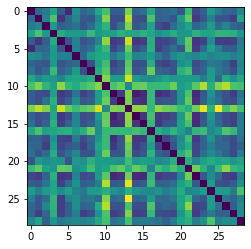

In [34]:
## sort the images by target (i.e., interaction_type)
pl.imshow(res)

In [ ]:
## clustering on the dissimilarity matrix - hclust in R
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_data = linkage(data, method='ward', metric='euclidean')
dendrogram(linkage_data)

## Hierarchical clustering on the RDM

https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

In [87]:
import numpy as np
from scipy.spatial.distance import squareform
from sklearn import datasets
!pip install fastcluster
from fastcluster import linkage

import matplotlib.pyplot as plt

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat, method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method, preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    for i in np.arange(len(a)):
        seriated_dist[a[i], b[i]] = dist_mat.samples[res_order[a[i]], res_order[b[i]]]
        seriated_dist[b[i], a[i]] = seriated_dist[a[i], b[i]]

    return seriated_dist, res_order, res_linkage

Method:	 ward


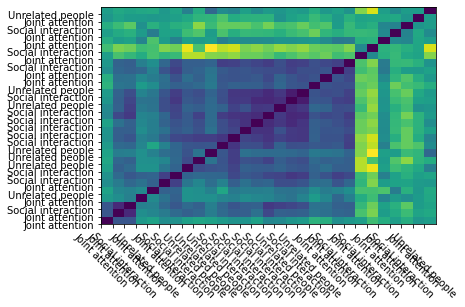

Method:	 single


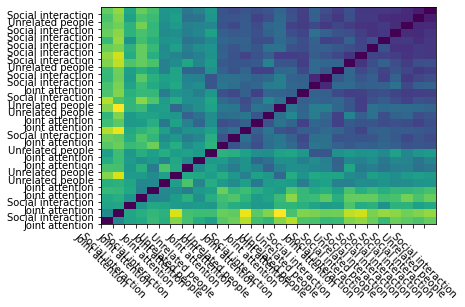

Method:	 average


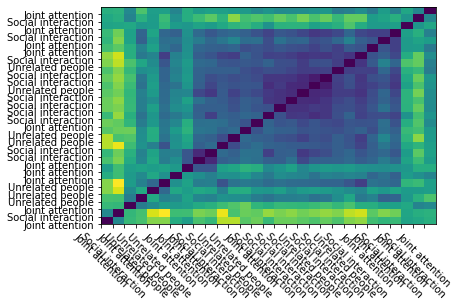

Method:	 complete


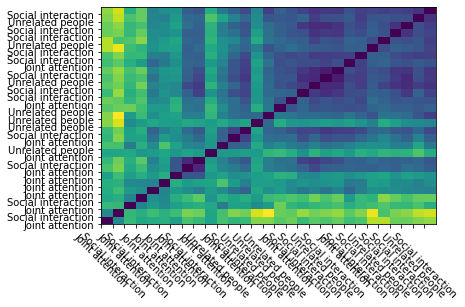

In [91]:
methods = ["ward","single","average","complete"]
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(res, method)
    
    plt.pcolormesh(ordered_dist_mat)
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.xticks(range(len(res)), res.sa.targets[res_order], rotation=-45)
    plt.yticks(range(len(res)), res.sa.targets[res_order])
    plt.show()